In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd

# k-means (inertia)

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


def inertia(dataframe, n_clusters=3, n_seeds=5):
    """ Cluster the data into `n_clusters` parts across `n_seeds` runs and
    return the minimum inertia. Record labelling (for post-run analysis.) """

    sc = MinMaxScaler().fit(dataframe)
    dataframe = sc.transform(dataframe)
    inertias, labels, centres = [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(dataframe)
        inertias.append(km.inertia_)
        labels.append(km.labels_)
        centres.append(sc.inverse_transform(km.cluster_centers_))

    best = min(inertias)
    idx = inertias.index(best)
    return best, labels[idx], centres[idx]

In [3]:
out = pathlib.Path("../data/kmeans_inertia/")
summary = pd.read_csv(out / "summary/main.csv")

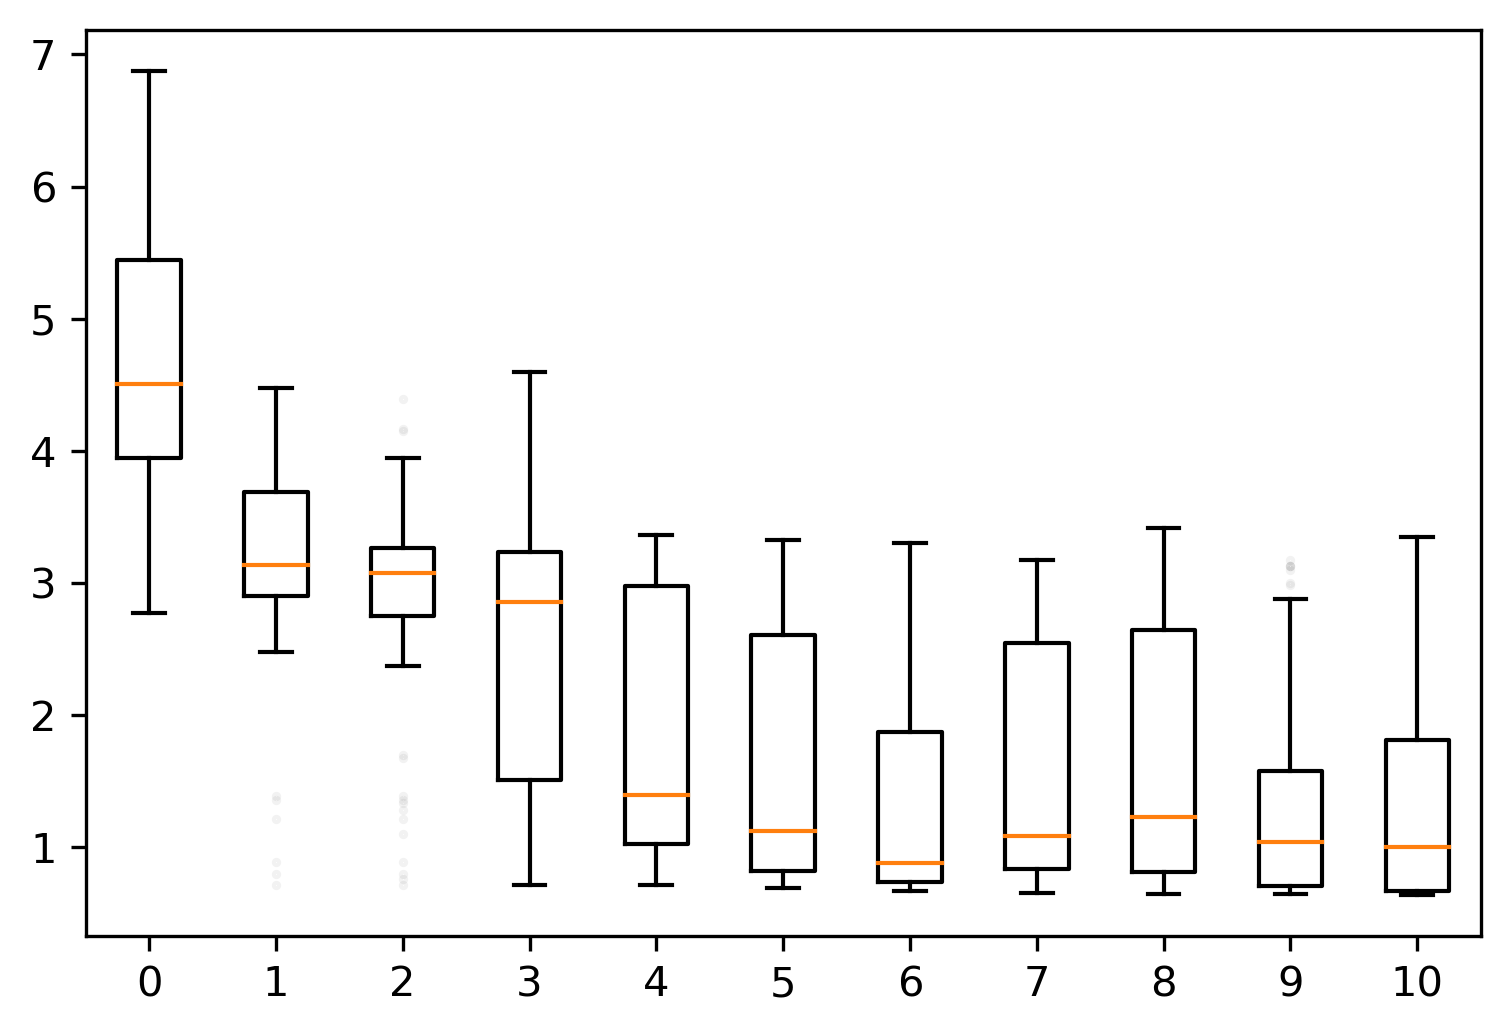

In [4]:
_, ax = plt.subplots(dpi=300)

flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

for gen, fits in summary.groupby("generation")["fitness"]:
    ax.boxplot(fits, positions=[gen], widths=0.5, flierprops=flierprops)

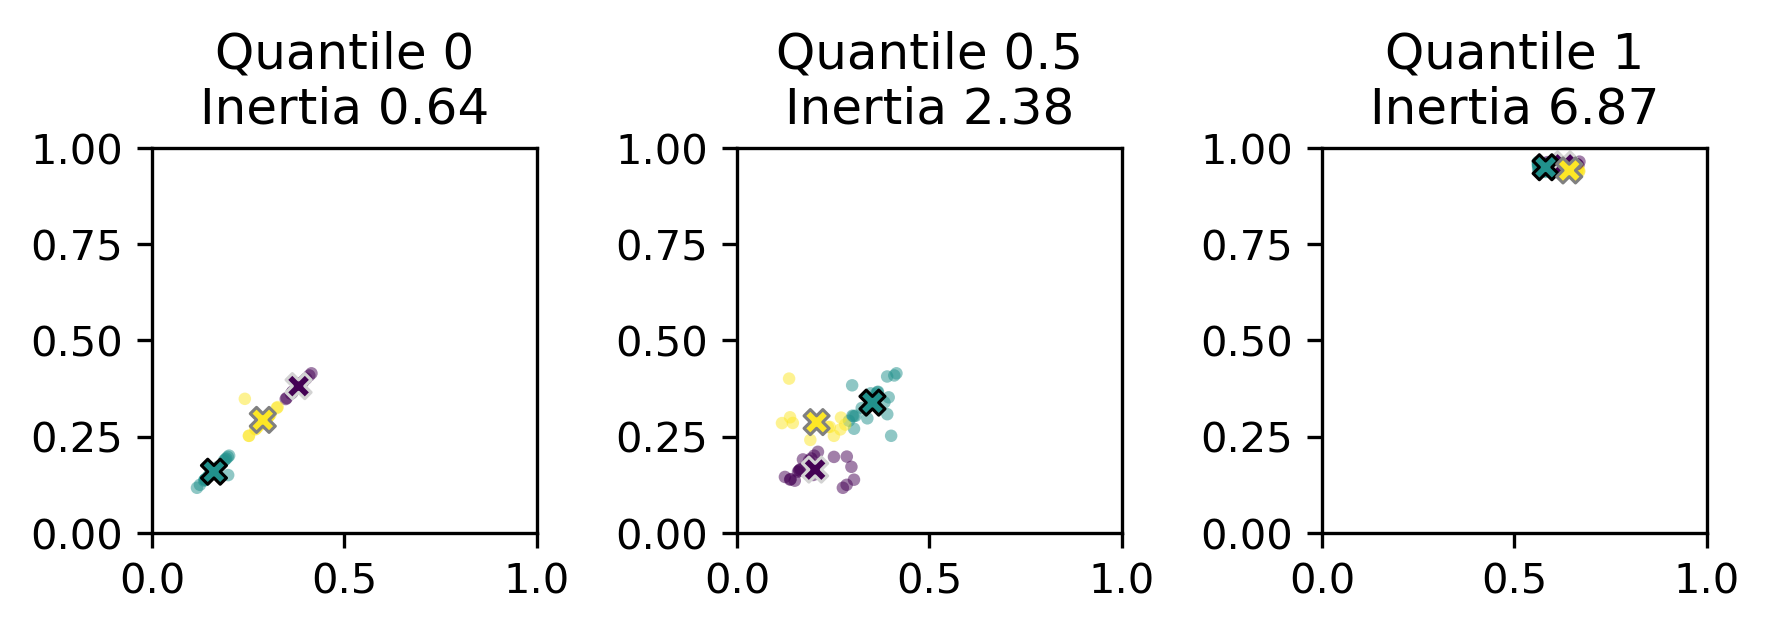

In [5]:
_, axes = plt.subplots(ncols=3, dpi=300)

for quantile, ax in zip(("0", "0.5", "1"), axes):

    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    inert, labels, centres = inertia(dataframe)
    
    ax.scatter(dataframe["0"], dataframe["1"], marker=".", c=labels, ec="None", alpha=0.5)
    ax.scatter(centres[:, 0], centres[:, 1], marker="X", c=[0, 1, 2], ec=["lightgray", "k", "gray"], lw=0.75)

    ax.set(xlim=(0, 1), ylim=(0, 1), aspect="equal", title=f"Quantile {quantile}\nInertia {inert:.2f}")

plt.tight_layout()

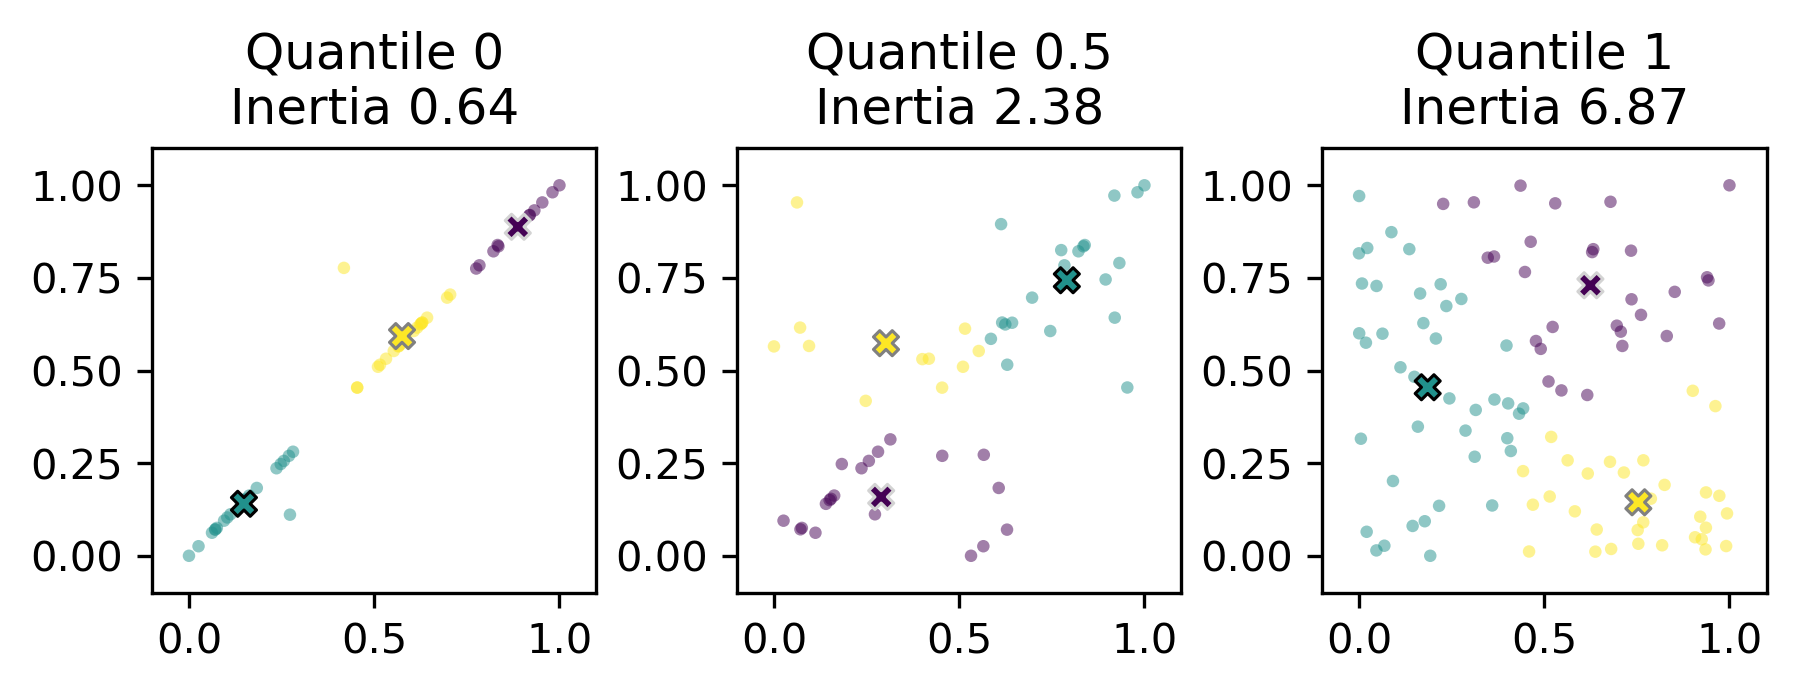

In [6]:
_, axes = plt.subplots(ncols=3, dpi=300)

for quantile, ax in zip(("0", "0.5", "1"), axes):

    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    sc = MinMaxScaler().fit(dataframe)
    data = sc.transform(dataframe)
    inert, labels, centres = inertia(dataframe)

    centres = sc.transform(centres)

    ax.scatter(data[:, 0], data[:, 1], marker=".", c=labels, ec="None", alpha=0.5)
    ax.scatter(centres[:, 0], centres[:, 1], marker="X", c=[0, 1, 2], ec=["lightgray", "k", "gray"], lw=0.75)
    
    ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nInertia {inert:.2f}")

plt.tight_layout()

# k-means (silhouette)

In [7]:
from sklearn.metrics import silhouette_score

In [8]:
def silhouette(dataframe, n_clusters=3, n_seeds=5):
    """ Cluster the data into `n_clusters` parts across `n_seeds` runs and
    return the minimum inertia. Record labelling (for post-run analysis.) """

    sc = MinMaxScaler().fit(dataframe)
    dataframe = sc.transform(dataframe)
    silhouettes, inertias, labels, centres = [], [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(dataframe)
        silhouettes.append(silhouette_score(dataframe, km.labels_))
        inertias.append(km.inertia_)
        labels.append(km.labels_)
        centres.append(sc.inverse_transform(km.cluster_centers_))

    best = min(silhouettes)
    idx = silhouettes.index(best)
    return best, inertias[idx], labels[idx], centres[idx]

In [9]:
out = pathlib.Path("../data/kmeans_silhouette/")
summary = pd.read_csv(out / "summary/main.csv")

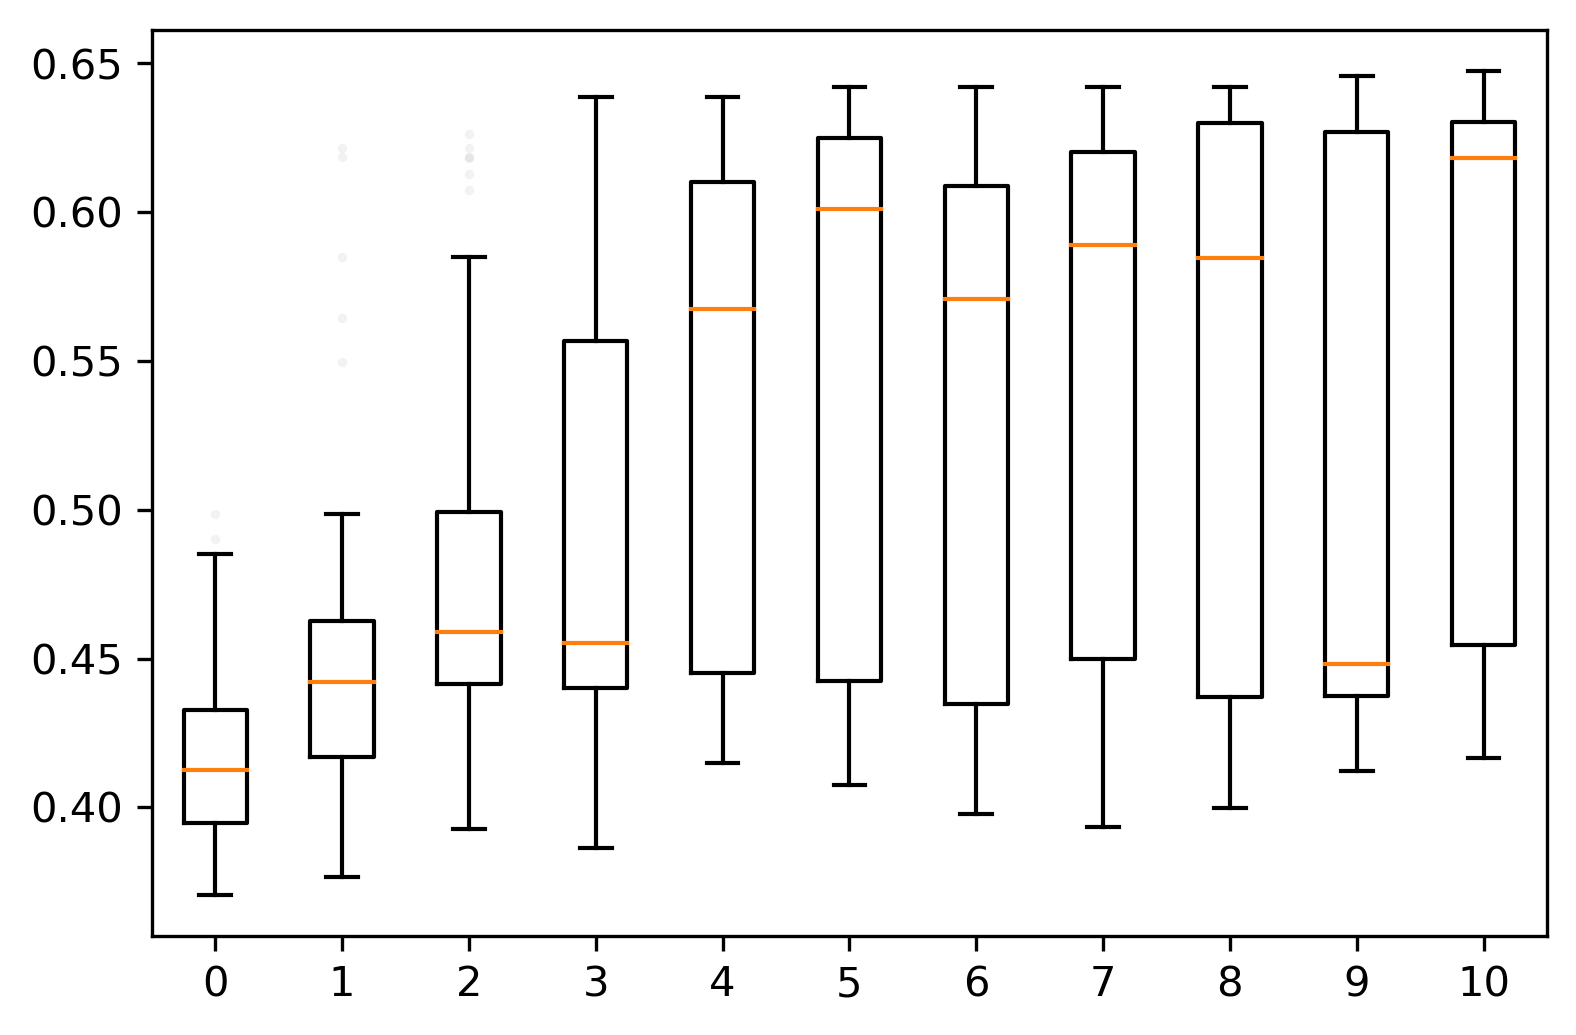

In [10]:
_, ax = plt.subplots(dpi=300)

flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

for gen, fits in summary.groupby("generation")["fitness"]:
    ax.boxplot(fits, positions=[gen], widths=0.5, flierprops=flierprops)

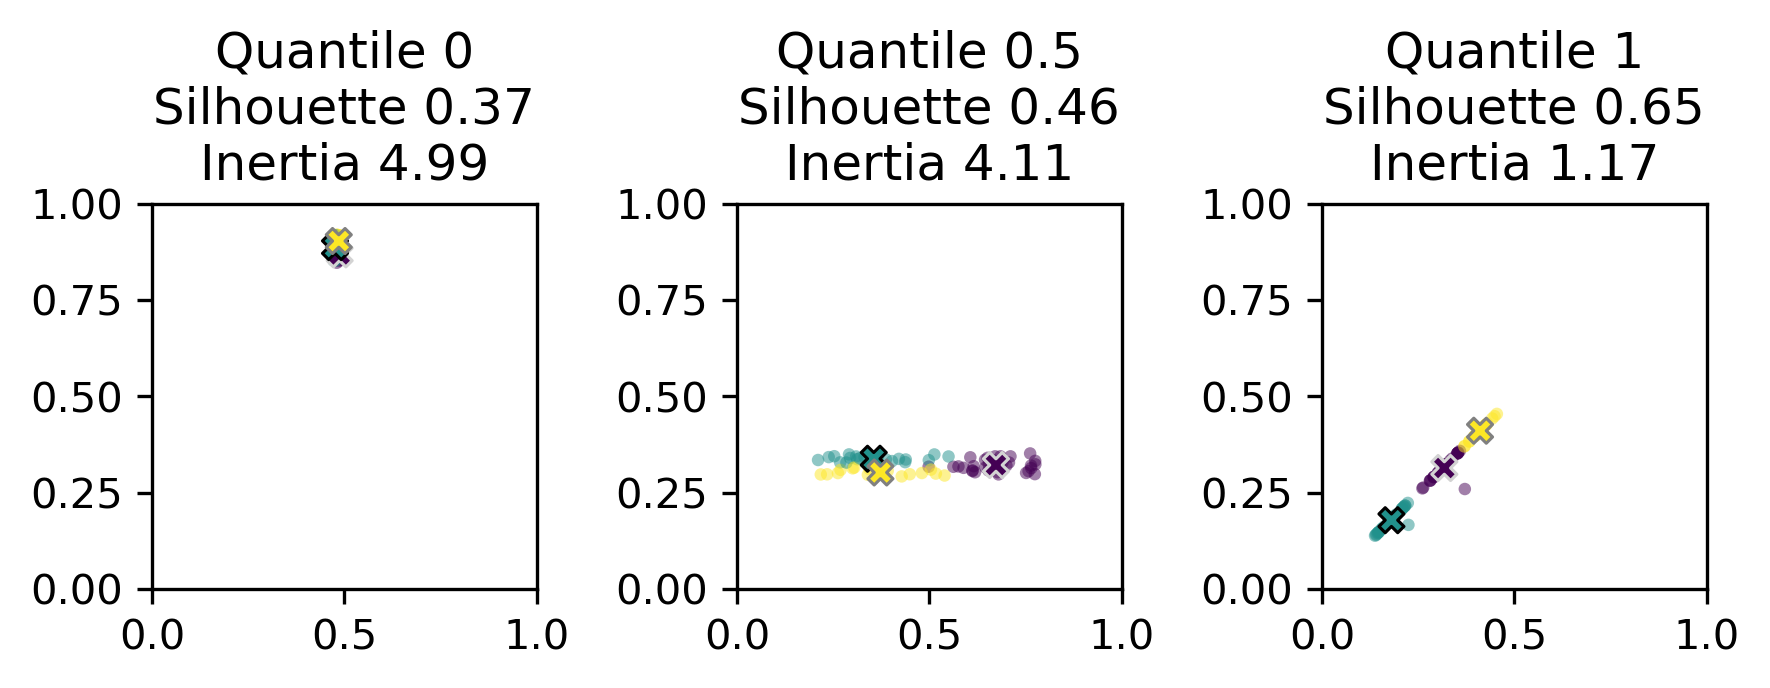

In [11]:
_, axes = plt.subplots(ncols=3, dpi=300)

for quantile, ax in zip(("0", "0.5", "1"), axes):

    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    score, inert, labels, centres = silhouette(dataframe)

    ax.scatter(dataframe["0"], dataframe["1"], marker=".", c=labels, ec="None", alpha=0.5)
    ax.scatter(centres[:, 0], centres[:, 1], marker="X", c=[0, 1, 2], ec=["lightgray", "k", "gray"], lw=0.75)
    
    ax.set(xlim=(0, 1), ylim=(0, 1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {score:.2f}\nInertia {inert:.2f}")

plt.tight_layout()

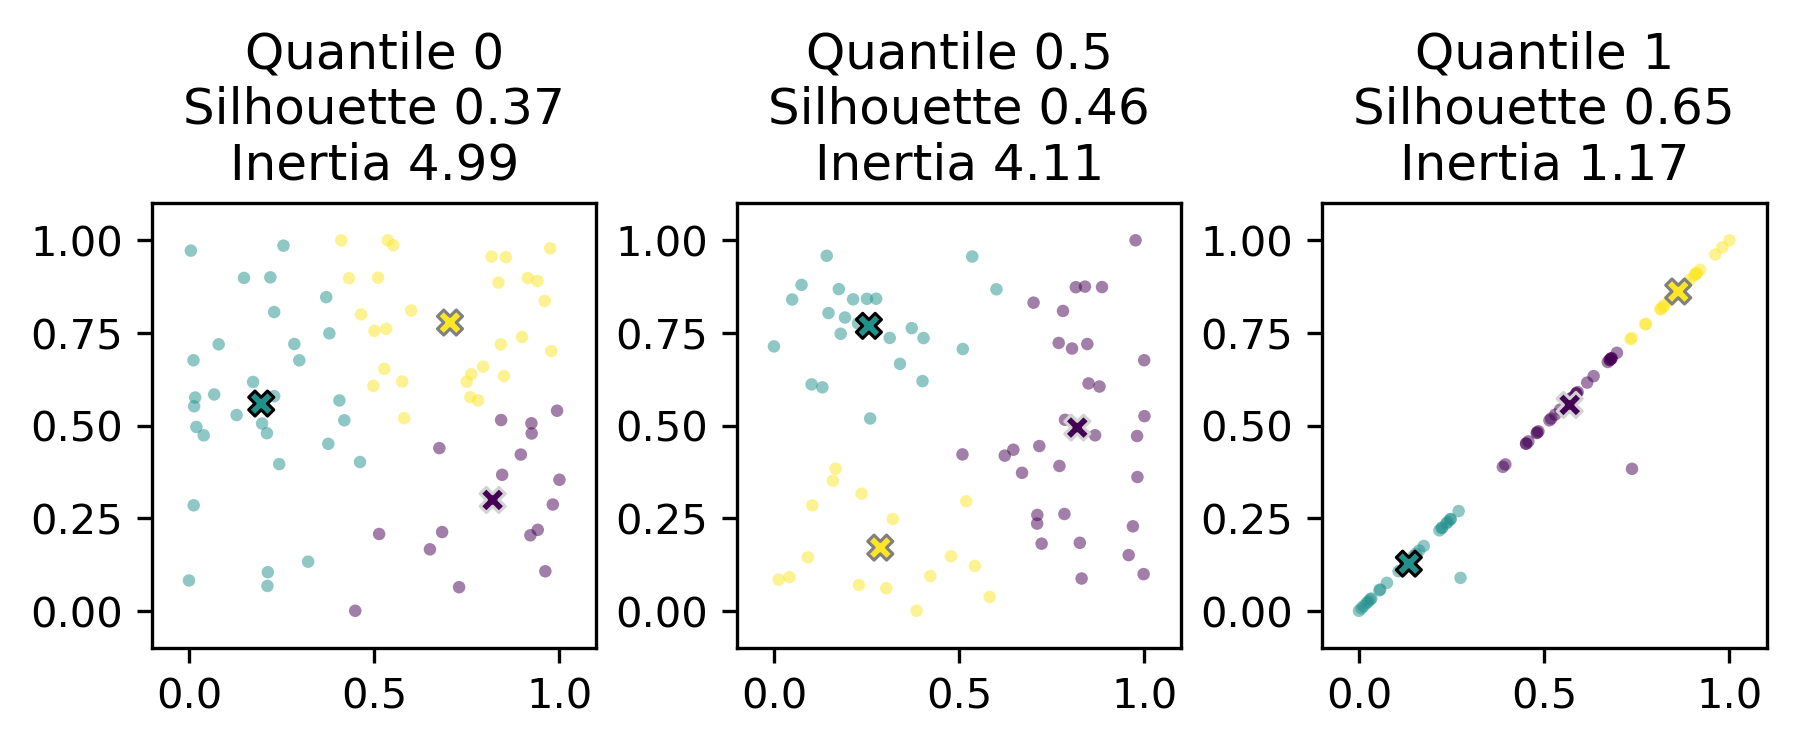

In [12]:
_, axes = plt.subplots(ncols=3, dpi=300)

for quantile, ax in zip(("0", "0.5", "1"), axes):

    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    sc = MinMaxScaler().fit(dataframe)
    data = sc.transform(dataframe)
    score, inert, labels, centres = silhouette(dataframe)

    centres = sc.transform(centres)

    ax.scatter(data[:, 0], data[:, 1], marker=".", c=labels, ec="None", alpha=0.5)
    ax.scatter(centres[:, 0], centres[:, 1], marker="X", c=[0, 1, 2], ec=["lightgray", "k", "gray"], lw=0.75)
    
    ax.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {score:.2f}\nInertia {inert:.2f}")

plt.tight_layout()

# k-means preferable

In [13]:
from sklearn.cluster import DBSCAN

In [32]:
def kmeans_preferable(dataframe, n_clusters=3, eps=0.1, min_samples=5, n_seeds=5):
    """ Cluster the data into `n_clusters` parts with k-means and with DBSCAN
    using `eps` and `min_samples` across `n_seeds` runs. Find the difference in
    their silhouette scores and return the largest. """

    sc = MinMaxScaler().fit(dataframe)
    dataframe = sc.transform(dataframe)
    differences, kmscores, dbscores, kmlabels, dblabels, = [], [], [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(dataframe)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataframe)

        kmlabels.append(km.labels_)
        dblabels.append(db.labels_)

        km_score = silhouette_score(dataframe, km.labels_)
        kmscores.append(km_score)

        outlier_mask = db.labels_ == -1
        labels = db.labels_[~outlier_mask]
        if len(set(labels)) > 1:
            data = dataframe[~outlier_mask, :]
            db_score = silhouette_score(data, labels)
            dbscores.append(db_score)
            differences.append(km_score - db_score)
        else:
            dbscores.append("nan")
            differences.append(-3)

    best = max(differences)
    idx = differences.index(best)
    return best, kmscores[idx], dbscores[idx], kmlabels[idx], dblabels[idx]

In [33]:
out = pathlib.Path("../data/kmeans_preferable/")
summary = pd.read_csv(out / "summary/main.csv")

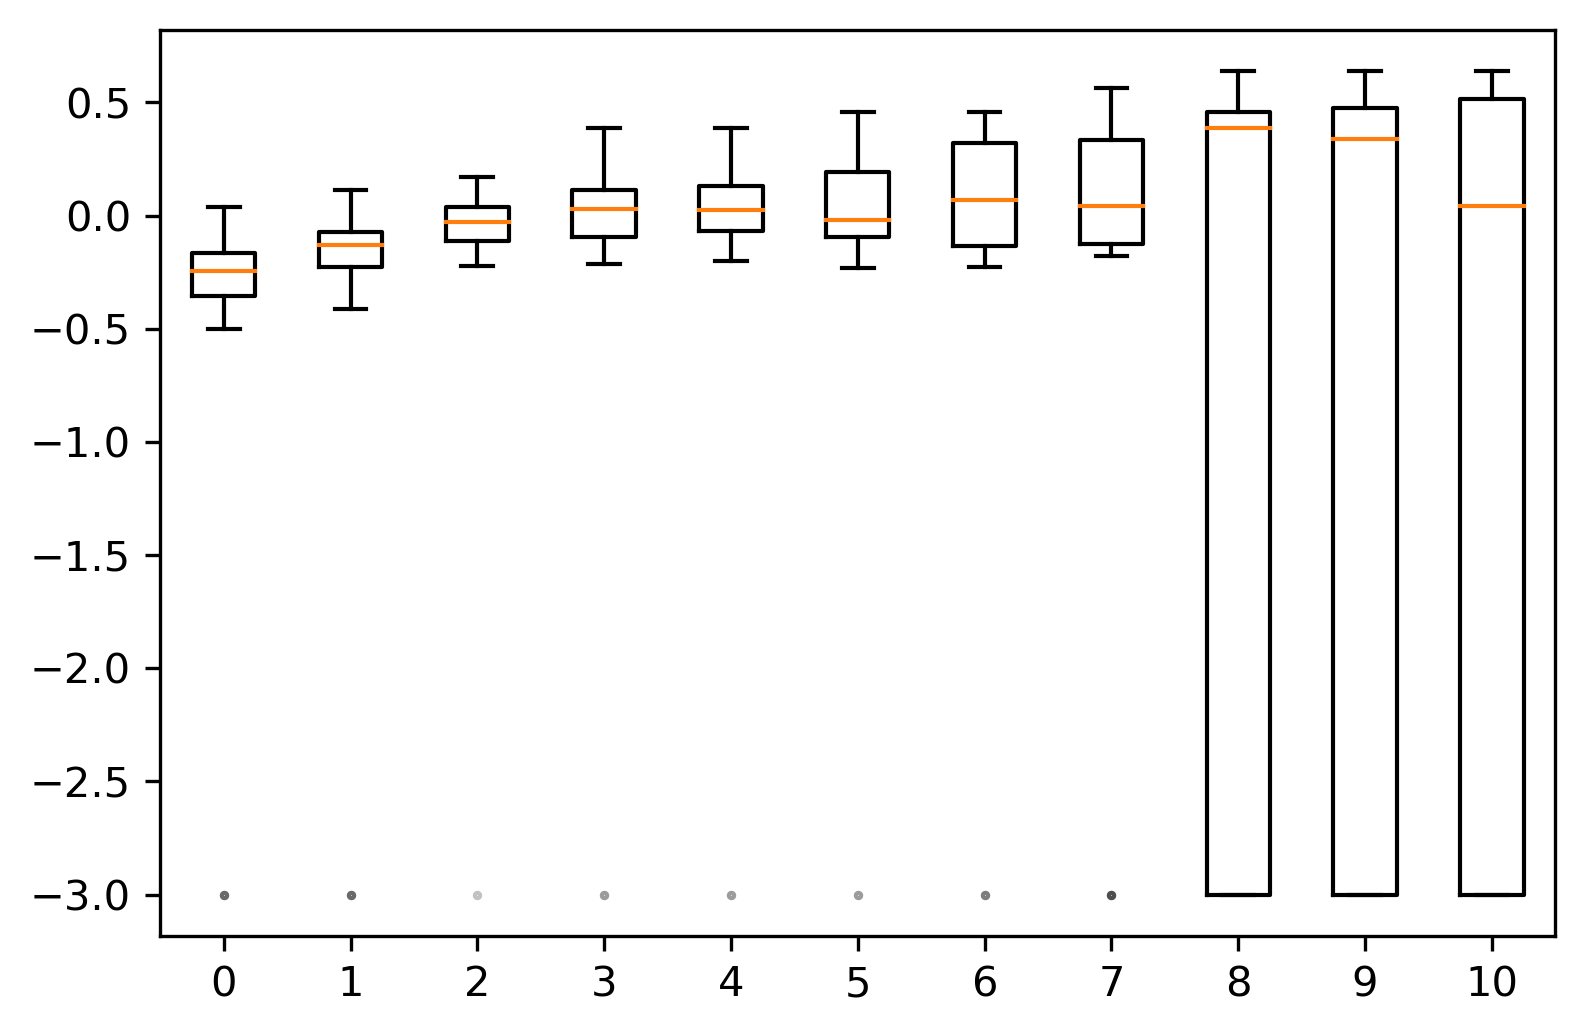

In [34]:
_, ax = plt.subplots(dpi=300)

flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

for gen, fits in summary.groupby("generation")["fitness"]:
    ax.boxplot(fits, positions=[gen], widths=0.5, flierprops=flierprops)

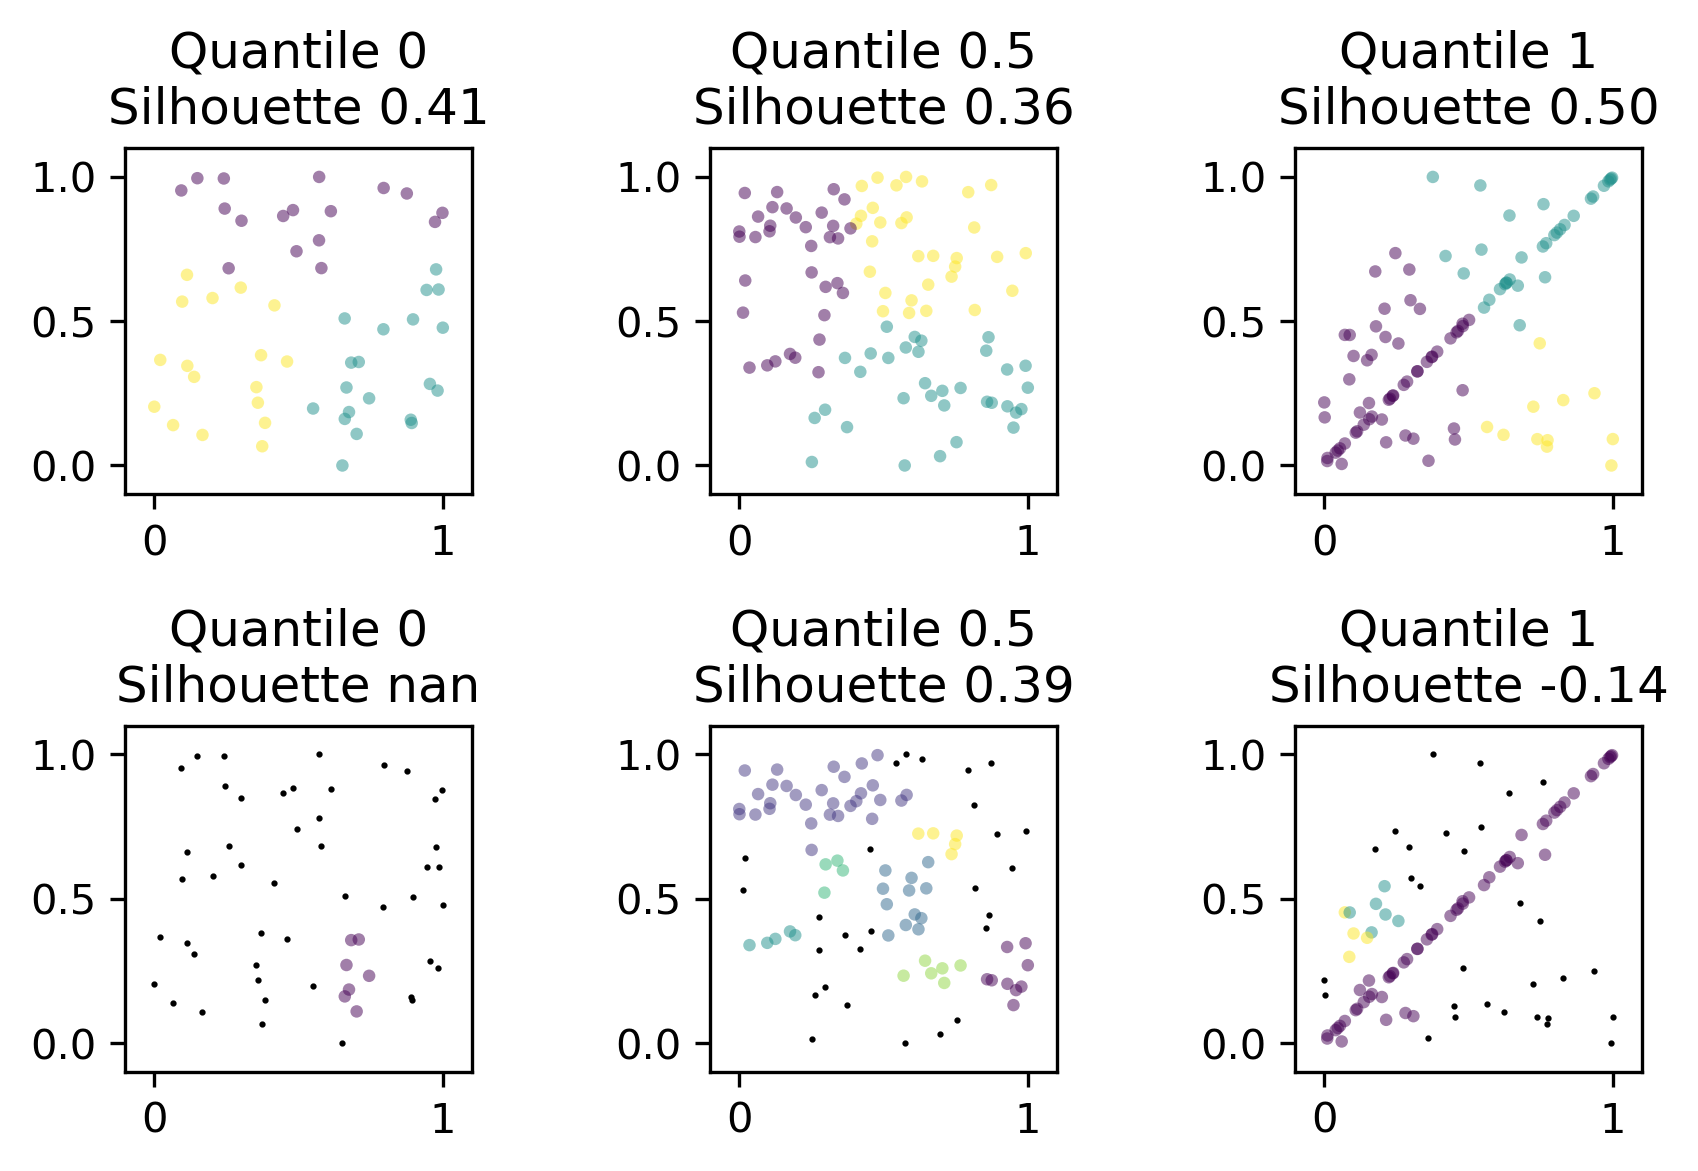

In [36]:
_, axes = plt.subplots(2, 3, dpi=300)

for quantile, (top, bot) in zip(("0", "0.5", "1"), axes.T):
    
    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    data = MinMaxScaler().fit_transform(dataframe)
    diff, kmscore, dbscore, kmlabels, dblabels = kmeans_preferable(dataframe)

    top.scatter(data[:, 0], data[:, 1], marker=".", c=kmlabels, ec="None", alpha=0.5)
    top.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {kmscore:.2f}")

    outlier_mask = dblabels == -1
    outliers = data[outlier_mask, :]
    bot.scatter(
        outliers[:, 0], outliers[:, 1], c="k", edgecolors="k", s=1, lw=0.5, zorder=2
    )

    inliers = data[~outlier_mask, :]
    inlabels = dblabels[~outlier_mask]
    bot.scatter(inliers[:, 0], inliers[:, 1], marker=".", c=inlabels, ec="None", alpha=0.5)
    dbscore = f"{dbscore:.2f}" if isinstance(dbscore, float) else dbscore
    bot.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {dbscore}")

plt.tight_layout()

# DBSCAN preferable

In [38]:
def dbscan_preferable(dataframe, n_clusters=3, eps=0.1, min_samples=5, n_seeds=5):
    """ Cluster the data with DBSCAN using `eps` and `min_samples`, and into
    `n_clusters` parts with k-means across `n_seeds` runs. Find the difference
    in their silhouette scores and return the largest. """

    sc = MinMaxScaler().fit(dataframe)
    dataframe = sc.transform(dataframe)

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataframe)
    outlier_mask = db.labels_ == -1
    labels = db.labels_[~outlier_mask]
    if len(set(labels)) > 1:
        data = dataframe[~outlier_mask, :]
        db_score = silhouette_score(data, labels)
    else:
        db_score = None

    differences, kmscores, dbscores, kmlabels = [], [], [], []
    for seed in range(n_seeds):
        km = KMeans(n_clusters, random_state=seed).fit(dataframe)
        kmlabels.append(km.labels_)

        km_score = silhouette_score(dataframe, km.labels_)
        kmscores.append(km_score)

        if db_score is not None:
            differences.append(db_score - km_score)
        else:
            dbscores.append("nan")
            differences.append(-3)

    best = max(differences)
    idx = differences.index(best)
    return best, kmscores[idx], dbscores[idx], kmlabels[idx], db.labels_

In [39]:
out = pathlib.Path("../data/dbscan_preferable/")
summary = pd.read_csv(out / "summary/main.csv")

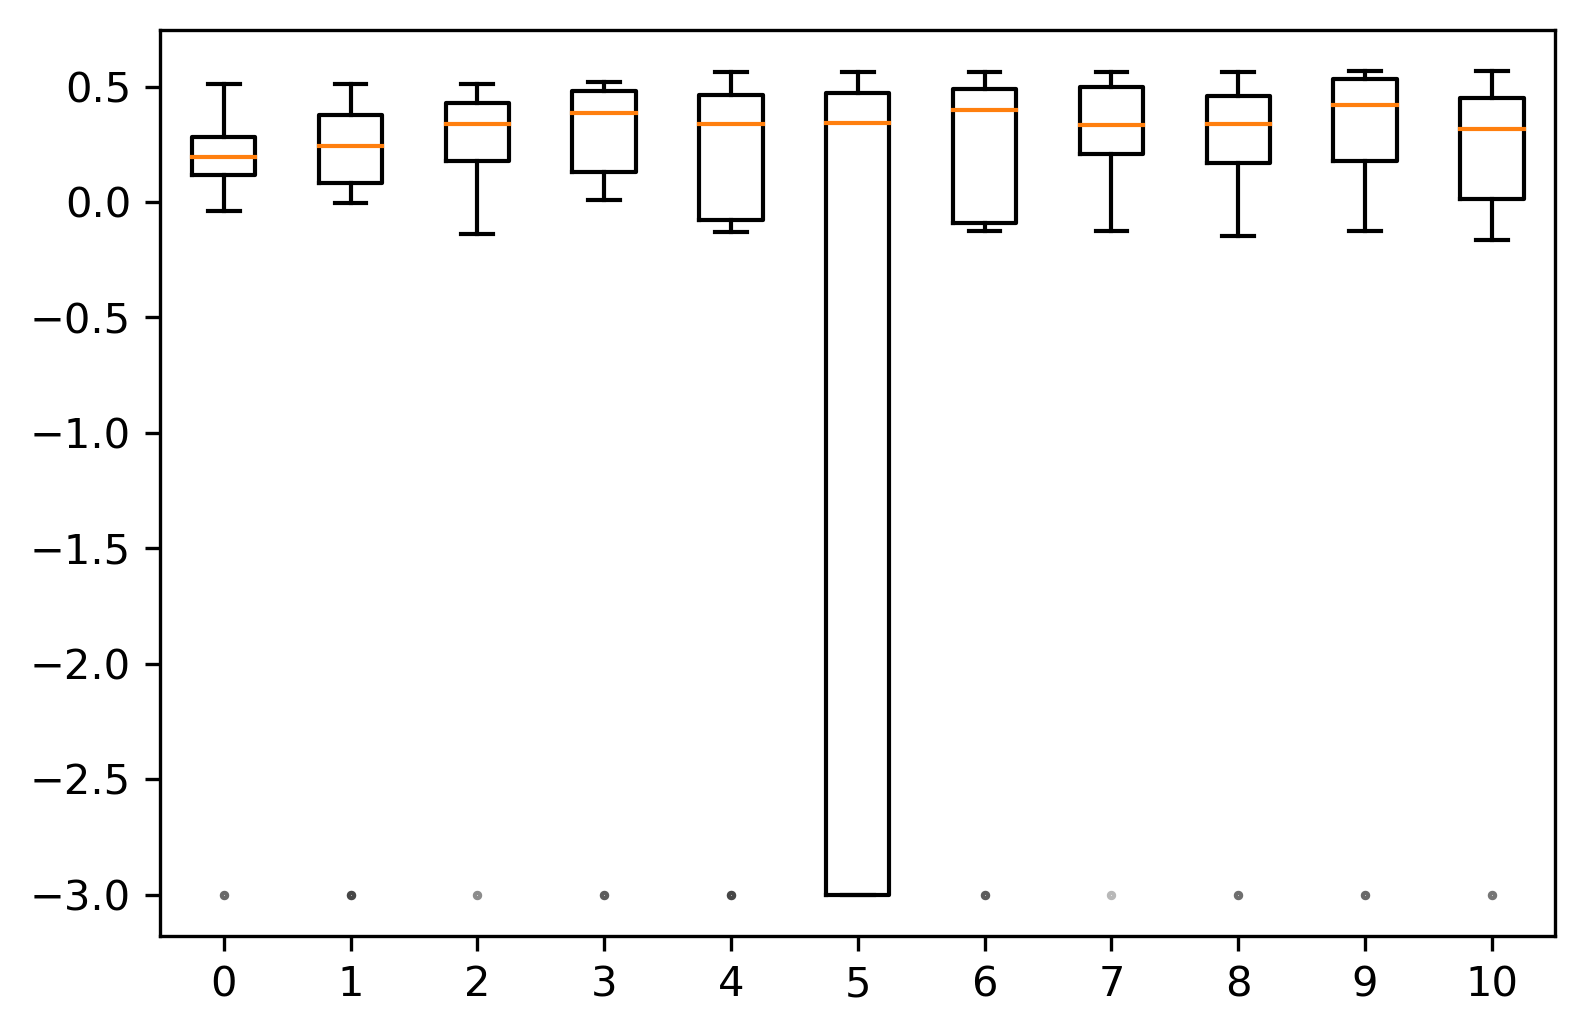

In [40]:
_, ax = plt.subplots(dpi=300)

flierprops = dict(marker=".", markersize=2.5, linestyle="none", alpha=0.05)

for gen, fits in summary.groupby("generation")["fitness"]:
    ax.boxplot(fits, positions=[gen], widths=0.5, flierprops=flierprops)

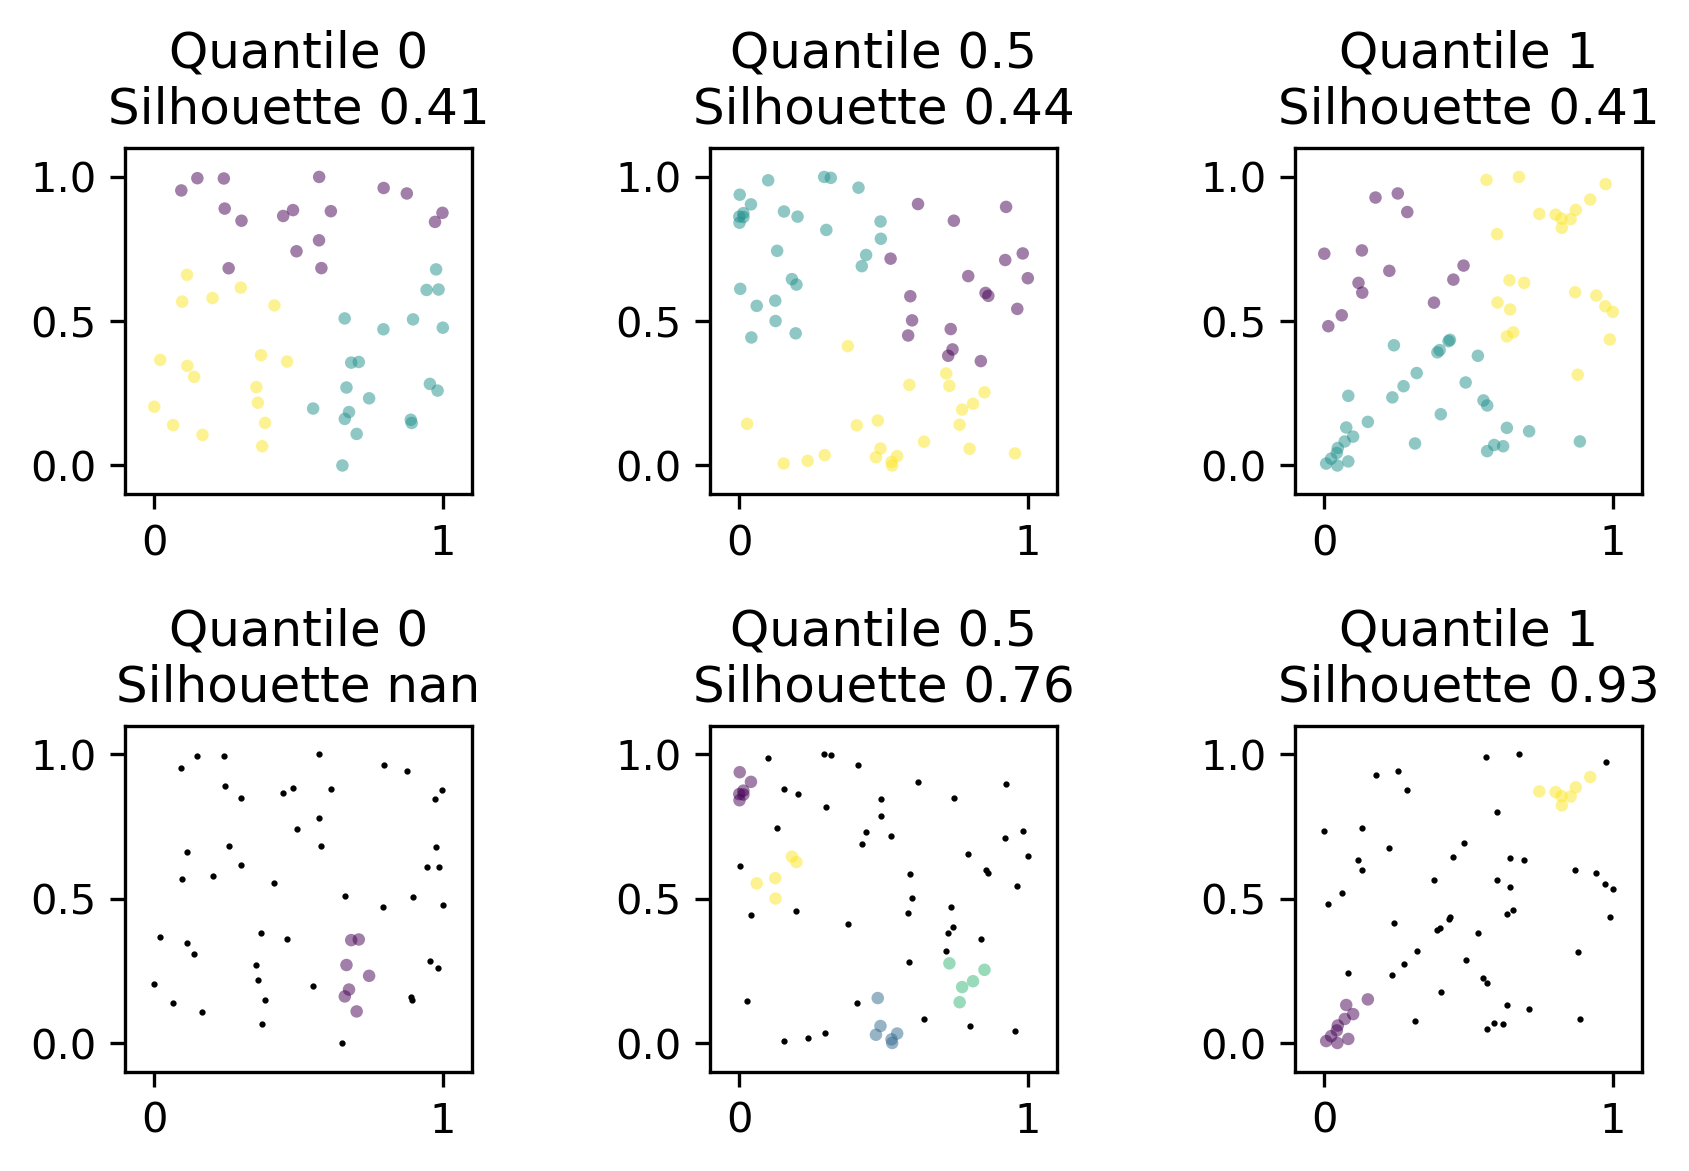

In [42]:
_, axes = plt.subplots(2, 3, dpi=300)

for quantile, (top, bot) in zip(("0", "0.5", "1"), axes.T):
    
    dataframe = pd.read_csv(out / "summary" / quantile / "main.csv")
    data = MinMaxScaler().fit_transform(dataframe)
    diff, kmscore, dbscore, kmlabels, dblabels = kmeans_preferable(dataframe)

    top.scatter(data[:, 0], data[:, 1], marker=".", c=kmlabels, ec="None", alpha=0.5)
    top.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {kmscore:.2f}")

    outlier_mask = dblabels == -1
    outliers = data[outlier_mask, :]
    bot.scatter(
        outliers[:, 0], outliers[:, 1], c="k", edgecolors="k", s=1, lw=0.5, zorder=2
    )

    inliers = data[~outlier_mask, :]
    inlabels = dblabels[~outlier_mask]
    bot.scatter(inliers[:, 0], inliers[:, 1], marker=".", c=inlabels, ec="None", alpha=0.5)
    dbscore = f"{dbscore:.2f}" if isinstance(dbscore, float) else dbscore
    bot.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1), aspect="equal", title=f"Quantile {quantile}\nSilhouette {dbscore}")

plt.tight_layout()